

```
# This is formatted as code
```

# Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import drive

drive.mount("/content/drive")
%cd /content/drive/MyDrive/Capstone/Data/cleaned/
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1vzI5qEHuzB31gSTnOrTquwU_Kg35t7Z5/Capstone/Data/cleaned
foo.png                    Manufacturing.xlsx  Service_filled.xlsx
Manufacturing_filled.xlsx  model.png           Service.xlsx


In [16]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [17]:
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [18]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [19]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [20]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

In [21]:
m_dfs.keys()

dict_keys([('AUS', 'Mean'), ('BRA', 'Mean'), ('CAN', 'Mean'), ('CHN', 'Mean'), ('GBR', 'Mean'), ('IND', 'Mean'), ('JPN', 'Mean'), ('SGP', 'Mean'), ('USA', 'Mean'), ('AUS', 'Median'), ('BRA', 'Median'), ('CAN', 'Median'), ('CHN', 'Median'), ('GBR', 'Median'), ('IND', 'Median'), ('JPN', 'Median'), ('SGP', 'Median'), ('USA', 'Median'), ('AUS', 'LOCF'), ('BRA', 'LOCF'), ('CAN', 'LOCF'), ('CHN', 'LOCF'), ('GBR', 'LOCF'), ('IND', 'LOCF'), ('JPN', 'LOCF'), ('SGP', 'LOCF'), ('USA', 'LOCF'), ('AUS', 'NOCB'), ('BRA', 'NOCB'), ('CAN', 'NOCB'), ('CHN', 'NOCB'), ('GBR', 'NOCB'), ('IND', 'NOCB'), ('JPN', 'NOCB'), ('SGP', 'NOCB'), ('USA', 'NOCB'), ('AUS', 'Rolling statistics'), ('BRA', 'Rolling statistics'), ('CAN', 'Rolling statistics'), ('CHN', 'Rolling statistics'), ('GBR', 'Rolling statistics'), ('IND', 'Rolling statistics'), ('JPN', 'Rolling statistics'), ('SGP', 'Rolling statistics'), ('USA', 'Rolling statistics')])

In [41]:
aus_data_m = m_dfs[("AUS", "Rolling statistics")]
bra_data_m = m_dfs[("BRA", "Rolling statistics")]
can_data_m = m_dfs[("CAN", "Rolling statistics")]
chn_data_m = m_dfs[("CHN", "Rolling statistics")]
gbr_data_m = m_dfs[("GBR", "Rolling statistics")]
ind_data_m = m_dfs[("IND", "Rolling statistics")]
jpn_data_m = m_dfs[("JPN", "Rolling statistics")]
sgp_data_m = m_dfs[("SGP", "Rolling statistics")]
usa_data_m = m_dfs[("USA", "Rolling statistics")]

In [58]:
aus_data_s = s_dfs[("AUS", "Rolling statistics")]
bra_data_s = s_dfs[("BRA", "Rolling statistics")]
can_data_s = s_dfs[("CAN", "Rolling statistics")]
chn_data_s = s_dfs[("CHN", "Rolling statistics")]
gbr_data_s = s_dfs[("GBR", "Rolling statistics")]
ind_data_s = s_dfs[("IND", "Rolling statistics")]
jpn_data_s = s_dfs[("JPN", "Rolling statistics")]
sgp_data_s = s_dfs[("SGP", "Rolling statistics")]
usa_data_s = s_dfs[("USA", "Rolling statistics")]

# Prophet Model

In [43]:
def mse(y, yhat):
  res = 0
  for i in range(len(y)):
    res += (y[i] - yhat[i]) ** 2
  return res / len(y)

def rmse(y, yhat):
  res = 0
  for i in range(len(y)):
    res += (y[i] - yhat[i]) ** 2
  return (res / len(y)) ** 0.5

def mae(y, yhat):
  res = 0
  for i in range(len(y)):
    res += abs(y[i] - yhat[i])
  return res / len(y)

def mape(y, yhat):
  res = 0
  for i in range(len(y)):
    res += (abs(y[i] - yhat[i]) / y[i]) * 100
  return res / len(y)

In [49]:
def fit_model_m(data):
  prophet = Prophet(seasonality_mode='multiplicative')
  data = data.reset_index()
  data = data.rename(columns={'Year': "ds", "Manufacturing_value added_%_of_GDP": "y"})
  data_train = data[data['ds'] <= 2016]
  data_test = data[data['ds'] > 2016]
  data_test = list(data_test['y'])
  prophet.fit(data_train)
  future = prophet.make_future_dataframe(periods = 51, freq="YS").tail(42)
  forecast = prophet.predict(future)
  prophet.plot(forecast)
  print("--------------------Evaluation---------------------")
  print("MSE : ", mse(data_test, list(forecast['yhat'][-5:])))
  print("MAE : ", mae(data_test, list(forecast['yhat'][-5:])))
  print("MAPE : ", mape(data_test, list(forecast['yhat'][-5:])))
  print("--------------------Evaluation---------------------")
  return prophet

In [50]:
def fit_model_s(data):
  prophet = Prophet(seasonality_mode='multiplicative')
  data = data.reset_index()
  data = data.rename(columns={'Year': "ds", "Services_value_added_%_of_GDP": "y"})
  data_train = data[data['ds'] <= 2016]
  data_test = data[data['ds'] > 2016]
  data_test = list(data_test['y'])
  prophet.fit(data_train)
  future = prophet.make_future_dataframe(periods = 51, freq="YS").tail(42)
  forecast = prophet.predict(future)
  prophet.plot(forecast)
  print("--------------------Evaluation---------------------")
  print("MSE : ", mse(data_test, list(forecast['yhat'][-5:])))
  print("MAE : ", mae(data_test, list(forecast['yhat'][-5:])))
  print("MAPE : ", mape(data_test, list(forecast['yhat'][-5:])))
  print("--------------------Evaluation---------------------")
  return prophet

## Australia

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/vz0o4qrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/kjzvs4rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43633', 'data', 'file=/tmp/tmpjad4h45l/vz0o4qrj.json', 'init=/tmp/tmpjad4h45l/kjzvs4rr.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model3rw3lsut/prophet_model-20221022001037.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.21485672540715015
MAE :  0.41271432186571033
MAPE :  6.121746091561161
--------------------Evaluation---------------------


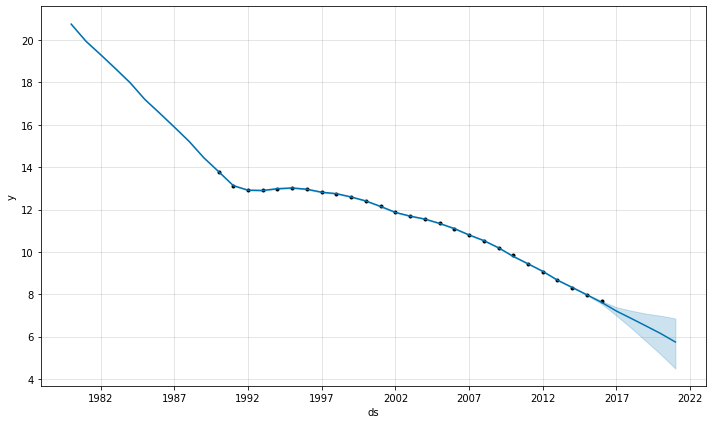

In [51]:
fit_model_m(aus_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/yasctczj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/i1ca0vod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55678', 'data', 'file=/tmp/tmpjad4h45l/yasctczj.json', 'init=/tmp/tmpjad4h45l/i1ca0vod.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelvg95dw4l/prophet_model-20221022001040.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:10:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.1343541595654732
MAE :  0.3079602044674175
MAPE :  0.46625386414646564
--------------------Evaluation---------------------


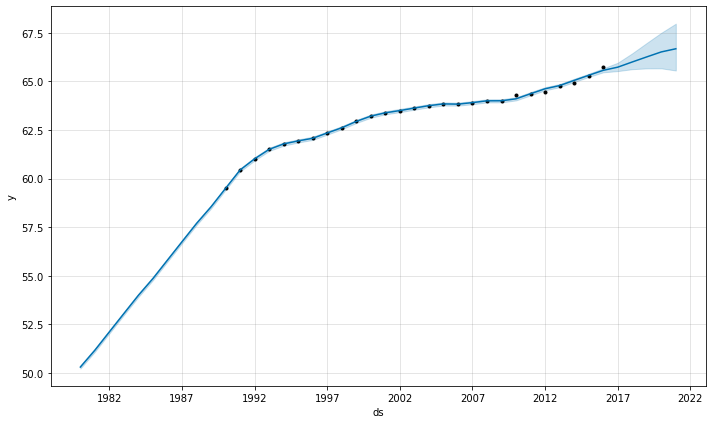

In [52]:
fit_model_s(aus_data_s)

## Brazil

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/ne5x63zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/92zh964k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75026', 'data', 'file=/tmp/tmpjad4h45l/ne5x63zg.json', 'init=/tmp/tmpjad4h45l/92zh964k.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelyg7fs899/prophet_model-20221022001109.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:11:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:11:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  12.941316614647576
MAE :  3.5424687569059268
MAPE :  31.416848603484407
--------------------Evaluation---------------------


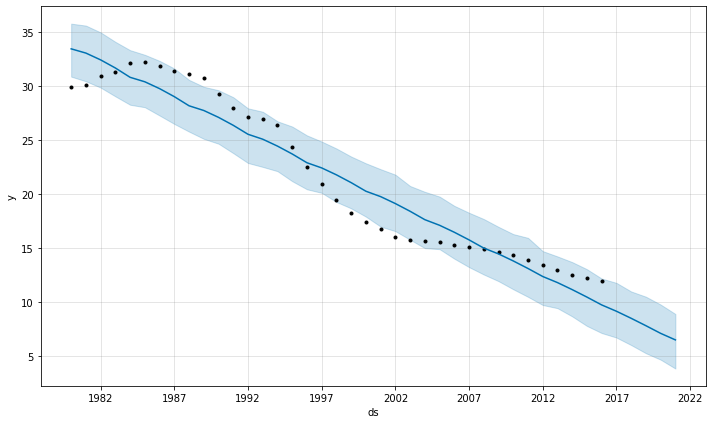

In [53]:
fit_model_m(bra_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/qpl_3jcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/ln1k6s_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31212', 'data', 'file=/tmp/tmpjad4h45l/qpl_3jcj.json', 'init=/tmp/tmpjad4h45l/ln1k6s_l.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modeluenot5fg/prophet_model-20221022001136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:11:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  0.6568157900753235
MAE :  0.7877017650847904
MAPE :  1.293232724700562
--------------------Evaluation---------------------


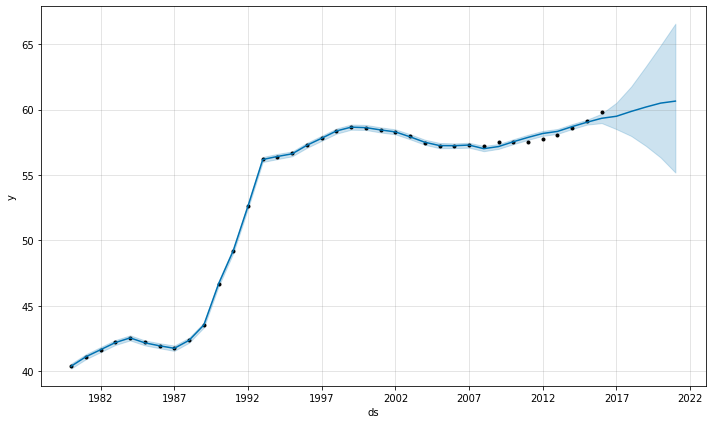

In [54]:
fit_model_s(bra_data_s)

## Canada

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/xmlmnc_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/1ltj55xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7766', 'data', 'file=/tmp/tmpjad4h45l/xmlmnc_w.json', 'init=/tmp/tmpjad4h45l/1ltj55xn.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model_0v0i2ua/prophet_model-20221022001155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

--------------------Evaluation---------------------
MSE :  0.07749174451932389
MAE :  0.26419816905810833
MAPE :  2.530847103273546
--------------------Evaluation---------------------


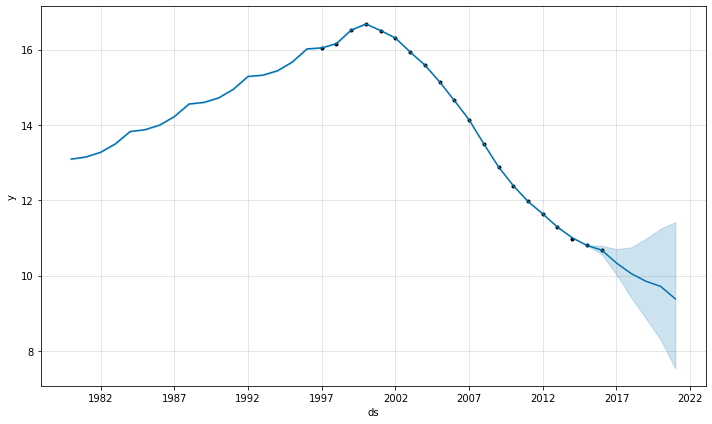

In [55]:
fit_model_m(can_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/y7k9h0tm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/6qhn59s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67527', 'data', 'file=/tmp/tmpjad4h45l/y7k9h0tm.json', 'init=/tmp/tmpjad4h45l/6qhn59s3.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelr39z9711/prophet_model-20221022001411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.024473988410377588
MAE :  0.1540506824778589
MAPE :  0.23421459366189623
--------------------Evaluation---------------------


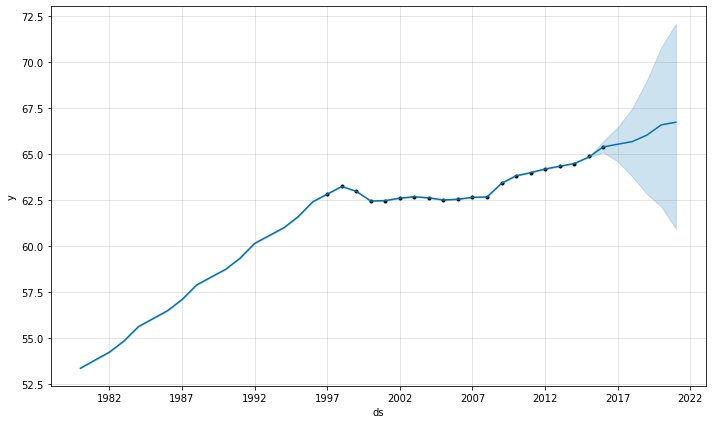

In [59]:
fit_model_s(can_data_s)

## China

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/4j7cshl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/img7g1s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63901', 'data', 'file=/tmp/tmpjad4h45l/4j7cshl5.json', 'init=/tmp/tmpjad4h45l/img7g1s8.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelqtmmwte0/prophet_model-20221022001437.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

--------------------Evaluation---------------------
MSE :  0.022481336286776073
MAE :  0.12671030488005214
MAPE :  0.4343821396244114
--------------------Evaluation---------------------


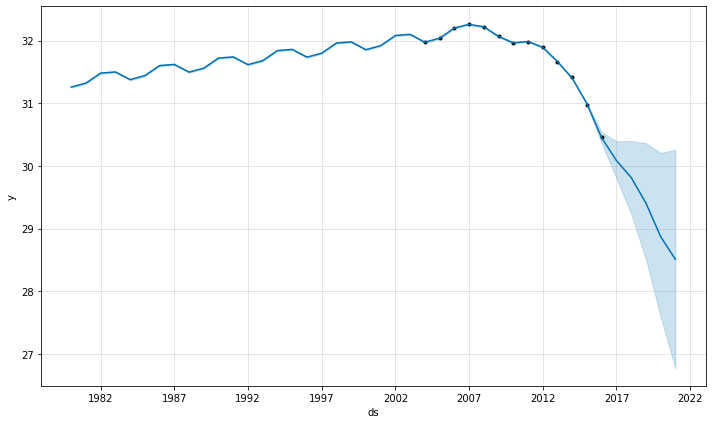

In [60]:
fit_model_m(chn_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/cqyilr42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/l41_nsj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43386', 'data', 'file=/tmp/tmpjad4h45l/cqyilr42.json', 'init=/tmp/tmpjad4h45l/l41_nsj1.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelt81onsg8/prophet_model-20221022001459.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  1.922365173046331
MAE :  1.3725373015585318
MAPE :  2.7887979196880543
--------------------Evaluation---------------------


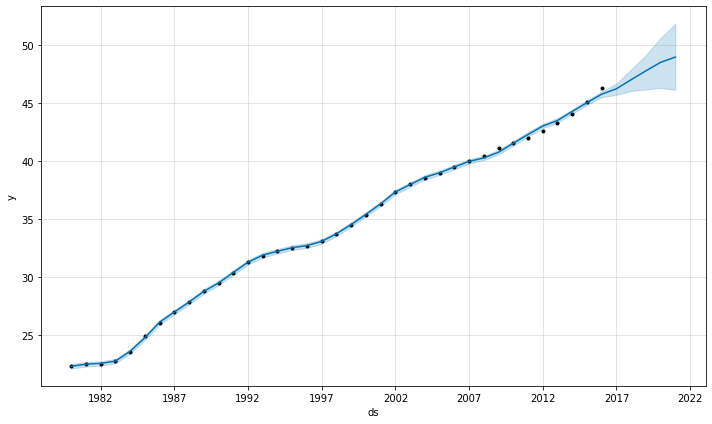

In [61]:
fit_model_s(chn_data_s)

## The United Kingdom

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/1e3znf2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/l04kgdju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1796', 'data', 'file=/tmp/tmpjad4h45l/1e3znf2k.json', 'init=/tmp/tmpjad4h45l/l04kgdju.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelat28ui7q/prophet_model-20221022001523.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:15:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

--------------------Evaluation---------------------
MSE :  0.029296695049180678
MAE :  0.1515585740340626
MAPE :  1.6221612536168166
--------------------Evaluation---------------------


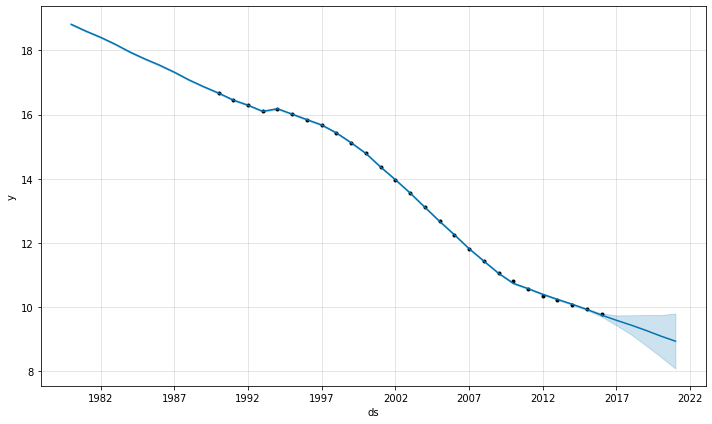

In [62]:
fit_model_m(gbr_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/f2uusqdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/qmyb2449.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62125', 'data', 'file=/tmp/tmpjad4h45l/f2uusqdf.json', 'init=/tmp/tmpjad4h45l/qmyb2449.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelm9u9aeji/prophet_model-20221022001631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:16:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.06749737957449702
MAE :  0.22556374409679164
MAPE :  0.3193150846084877
--------------------Evaluation---------------------


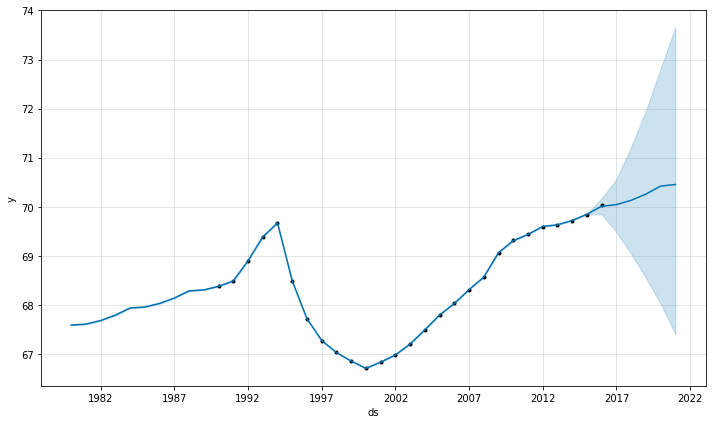

In [66]:
fit_model_s(gbr_data_s)

## India

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/042gkn4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/myyplugi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19258', 'data', 'file=/tmp/tmpjad4h45l/042gkn4z.json', 'init=/tmp/tmpjad4h45l/myyplugi.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model_u8qhzfq/prophet_model-20221022001651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  0.877656097734854
MAE :  0.8802202139757711
MAPE :  5.810670113590662
--------------------Evaluation---------------------


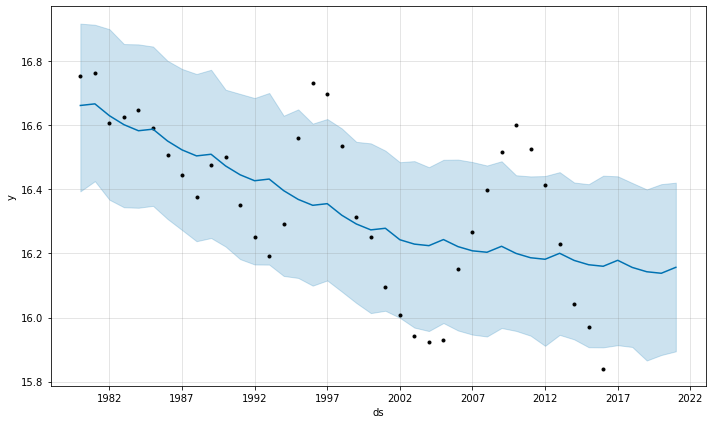

In [67]:
fit_model_m(ind_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/zz7msbuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/9s1o9n3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98957', 'data', 'file=/tmp/tmpjad4h45l/zz7msbuq.json', 'init=/tmp/tmpjad4h45l/9s1o9n3t.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelhniyhe7j/prophet_model-20221022001705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  0.01890724658650656
MAE :  0.105882180287864
MAPE :  0.22402782212192607
--------------------Evaluation---------------------


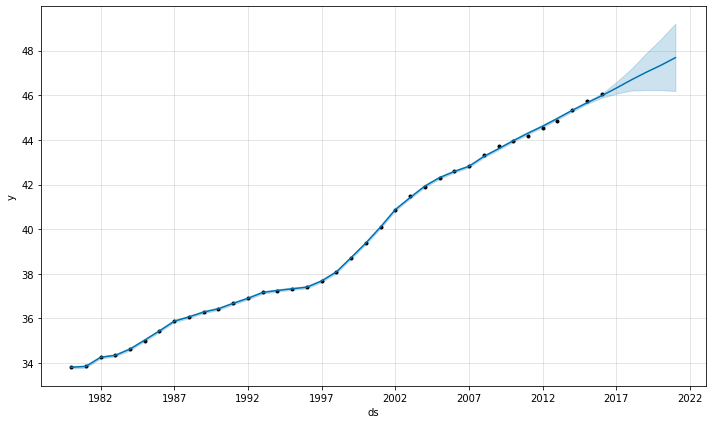

In [68]:
fit_model_s(ind_data_s)

## Japan

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/2q4f6rfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/7rywfpbz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63838', 'data', 'file=/tmp/tmpjad4h45l/2q4f6rfc.json', 'init=/tmp/tmpjad4h45l/7rywfpbz.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model6d89wvfu/prophet_model-20221022001723.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.1850039026128449
MAE :  0.4288823208017707
MAPE :  2.1102389983598346
--------------------Evaluation---------------------


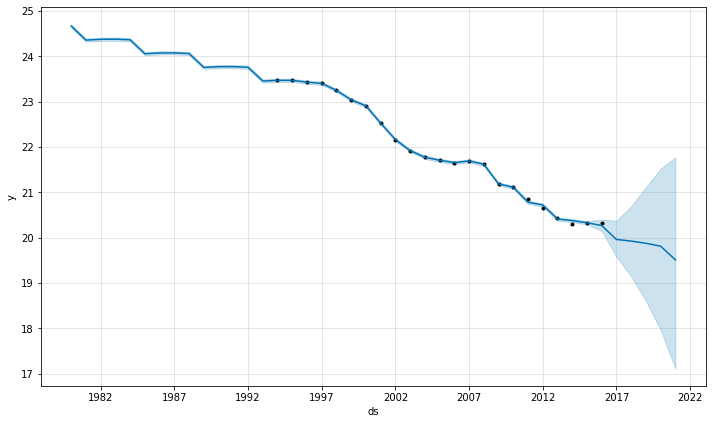

In [69]:
fit_model_m(jpn_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/_oaf21p6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/_dyuqisf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17789', 'data', 'file=/tmp/tmpjad4h45l/_oaf21p6.json', 'init=/tmp/tmpjad4h45l/_dyuqisf.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelc3jeolq5/prophet_model-20221022001740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:17:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.6121047541290021
MAE :  0.7745571543498357
MAPE :  1.1073209993737734
--------------------Evaluation---------------------


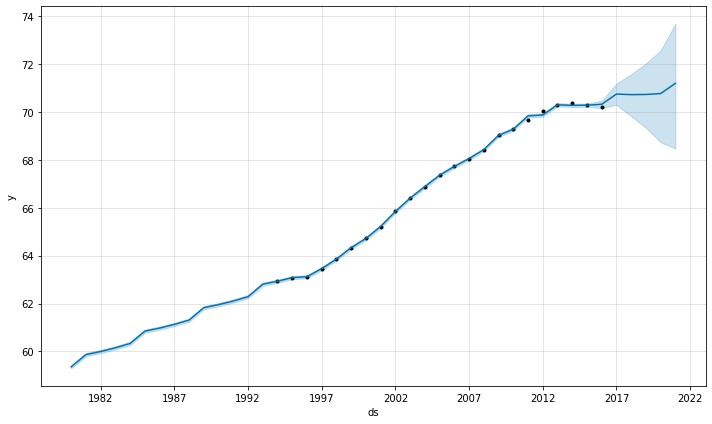

In [70]:
fit_model_s(jpn_data_s)

## Singapore

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/w_dax26g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/0os1a4w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4225', 'data', 'file=/tmp/tmpjad4h45l/w_dax26g.json', 'init=/tmp/tmpjad4h45l/0os1a4w3.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelpbyu1xbn/prophet_model-20221022001755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  3.834845649268735
MAE :  1.7581067936322576
MAPE :  8.839313736315617
--------------------Evaluation---------------------


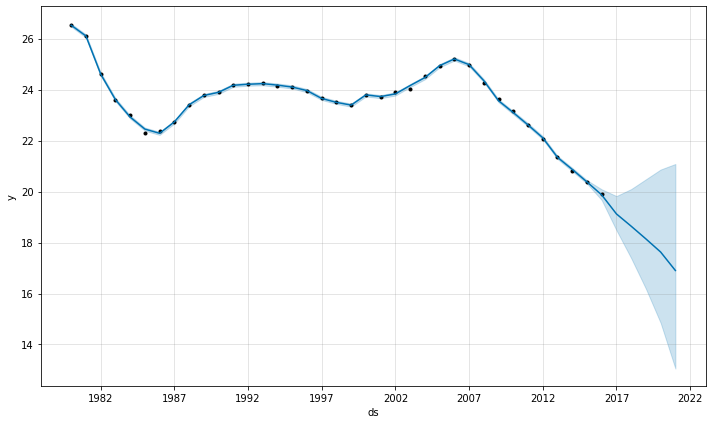

In [71]:
fit_model_m(sgp_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/655n5mt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/9dt2lw1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37068', 'data', 'file=/tmp/tmpjad4h45l/655n5mt7.json', 'init=/tmp/tmpjad4h45l/9dt2lw1f.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_modelknqga6pv/prophet_model-20221022001812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:18:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--------------------Evaluation---------------------
MSE :  1.1744589832601917
MAE :  1.000725019010406
MAPE :  1.4437127525492497
--------------------Evaluation---------------------


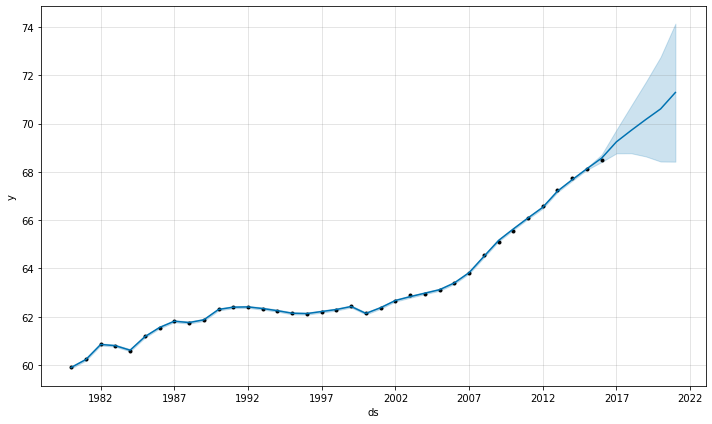

In [72]:
fit_model_s(sgp_data_s)

## The United States

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/fpawsuiy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/u9uoycui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28735', 'data', 'file=/tmp/tmpjad4h45l/fpawsuiy.json', 'init=/tmp/tmpjad4h45l/u9uoycui.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model7sc1tp1h/prophet_model-20221022001832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--------------------Evaluation---------------------
MSE :  0.0019916258130815616
MAE :  0.03243005258463505
MAPE :  0.27818648599107754
--------------------Evaluation---------------------


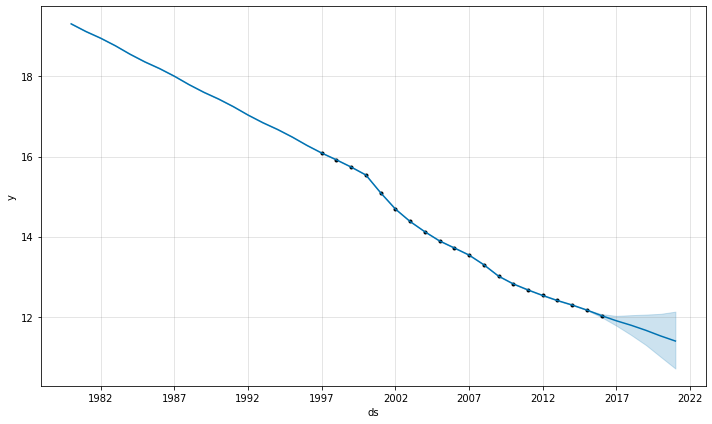

In [73]:
fit_model_m(usa_data_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/8mwwse5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjad4h45l/dm0udjfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7179', 'data', 'file=/tmp/tmpjad4h45l/8mwwse5h.json', 'init=/tmp/tmpjad4h45l/dm0udjfj.json', 'output', 'file=/tmp/tmpjad4h45l/prophet_model35wkt79n/prophet_model-20221022001844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

--------------------Evaluation---------------------
MSE :  0.03125722777643269
MAE :  0.13122898801063343
MAPE :  0.17116874098556797
--------------------Evaluation---------------------


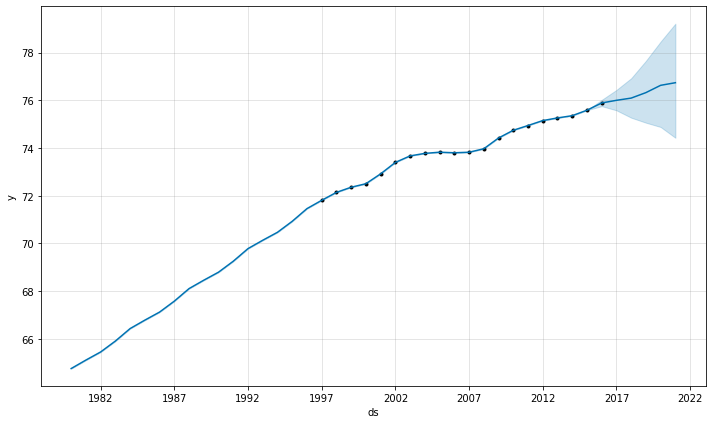

In [74]:
fit_model_s(usa_data_s)